杨帆（授课老师）:
1.	平时作业 40%：
	开课前7周，每周200行以上有效代码，共7次。提交格式01_31000000_派森.ipynb，发送至yuanxiaodu@gmail.com。 提交截止时间1月16日。少一次扣5分，单次作业不足200行，扣2分。
2.	大作业 60%：
	完成一个数据科学实践案例，实践内容至少包含数据抓取、数据处理、数据可视化。最后一次课（1月8日）以小组为单位对案例实现思路做报告（8分钟+2分钟点评）（30%），报告形式可以为流程图、UML图、架构图、以及包、类、函数的描述等。小组成员分数一致，报告人额外加5分。
	1月25日之前，以个人为单位提交代码，格式08_31000000_派森.ipynb（30%）。

杨帆（授课老师）:
注意，大作业提交格式也是ipynb


# 租房信息爬取及数据分析
### 近年来，持续高昂的房价将很多想要安身立命的人挡在了买房的门槛之外。在外漂泊的人们，只能暂时转向租赁市场寻求居住场所。尤其是刚毕业的大学生们，大部分只能通过租房来满足住房需求，购房行为代替给租房市场带来了巨大的规模和效益。本文使用爬虫爬北京贝壳租房的信息，然后进行一些探索和分析，了解租房市场行情。

# 实现流程
## 数据抓取
    数据抓取这里使用requests库，Requests 是用Python语言编写，基于 urllib，采用 Apache2 Licensed 开源协议的 HTTP 库。它比 urllib 更加方便，可以节约我们大量的工作，完全满足 HTTP 测试需求。Requests 的哲学是以 PEP 20 的习语为中心开发的，所以它比 urllib 更加 Pythoner。
 ## 数据解析
     数据解析使用lxml库的etree包，使用xpath语法方便的解析网页，因为解析得到的数据比较规范，因此就没有采用re正则表达式对其进行进一步处理lxml 是一种使用 Python 编写的库，可以迅速、灵活地处理 XML 和 HTML。它支持 XML Path Language (XPath) 和 Extensible Stylesheet Language Transformation (XSLT)，并且实现了常见的 ElementTree API。
 ## 数据存储
     为了后续方便进一步分析，爬取的数据最好储存到本地，这里我采用数据库进行存储，我选了sqlite数据库，SQLite是一个进程内的库，实现了自给自足的、无服务器的、零配置的、事务性的 SQL 数据库引擎。它是一个零配置的数据库，这意味着与其他数据库不一样，您不需要在系统中配置。就像其他数据库，SQLite 引擎不是一个独立的进程，可以按应用程序需求进行静态或动态连接。SQLite 直接访问其存储文件。
 ## 数据可视化
     Matplotlib是Python的一个2D图形库，能够生成各种格式的图形（诸如折线图，散点图，直方图等等），界面可交互（可以利用鼠标对生成图形进行点击操作），同时该2D图形库跨平台，即既可以在Python脚本中编码操作，也可以在Jupyter Notebook中使用，以及其他平台都可以很方便的使用Matplotlib图形库，而且生成图形质量较高，甚至可以达到出版级别。需要注意的是，在相关Python软件中调用Matplotlib图形库时，需要利用shell进行单独安装，假如使用Jupyter Notebook时，相关图形库已直接配置在软件内，不过其生成的图形无法进行交互，而是内嵌在Jupyter Notebook生成界面内。

# 代码展示
### 为了节省时间，这里只是爬取了北京东城区的租房信息

In [1]:
import requests
from lxml import etree
import sqlite3  # 操作sqlite数据库操作
import re
from time import sleep


def main():
    # 拿到不同地区的套数
    url = "https://bj.zu.ke.com/zufang"
    area_url, area_name = get_detail_url(url)
    print(area_url[0])
    datalist = get_data(area_url[0])
    print(datalist)
    path = "house_data.db"
    saveData2DB(path, datalist)


def get_html(url):
    """
    :param url: 初始url
    :return: 页面的etree对象
    """
    response = requests.get(url)
    text = response.content.decode("utf-8")
    html = etree.HTML(text)
    # print(html)

    return html


def get_detail_url(url):  # 获取不同地区的租房url
    html = get_html(url)
    ul = html.xpath("//ul[@data-target='area']")[0]
    li = ul.xpath('./li')
    area_url = []  # 北京不同区租房页面的url
    area_name = []  # 不同区的地名
    for i in li:
        area_url.append("https://bj.zu.ke.com" + i.xpath('./a/@href')[0])
        area_name.append(i.xpath("./a/text()")[0])
    return area_url[1:], area_name[1:]


def get_data(url):
    item_list = []
    for j in range(1, 69):
        print("正在爬取第%d页......." % j)
        sleep(10)
        html = get_html(url + "pg" + str(j) + "/#contentList")
        div = html.xpath("//div[@class='content__list--item']")
        item_url_list = []
        for item in div:
            item_url = item.xpath("./a[@class='content__list--item--aside']/@href")[0]
            if 'apartment' in item_url:
                continue
            else:
                item_url_list.append("https://bj.zu.ke.com" + item_url)
        # print(item_url_list, len(item_url_list))  # 获取到每个租房信息的url
        for i in range(len(item_url_list)):
            data = []  # 保存一所房子所有信息 这个list一定要放在for循环里面，每次重置为空列表

            # print(item_url_list[i])
            html = get_html(item_url_list[i])
            data.append(item_url_list[i])

            title = html.xpath("//p[@class='content__title']/text()")[0]  # 房源标题
            # print(title, type(title))
            data.append(title)

            div = html.xpath("//div[@class='content__core']")[0]
            price = div.xpath("./div/div[@class='content__aside--title']/span/text()")[0]  # 价格
            # print(price)
            data.append(price)

            mode = div.xpath("./div[@class='content__aside fr']/ul/li[1]/text()")[0]  # 租赁模式
            # print(mode)
            data.append(mode)

            ul = html.xpath(
                "//div[@class='content__detail']/div[@class='content__article fl']/div[@class='content__article__info']/ul[1]")[
                0]
            area = ul.xpath("./li[2]/text()")[0]
            # print(area)
            area = re.findall(r"\d+\.?\d*", area)[0]
            # print(area)
            data.append(area)

            toward = ul.xpath("./li[3]/text()")[0][-1]
            # print(toward)
            data.append(toward)

            item_list.append(data)
    print("爬取完毕！")

    return item_list


def saveData2DB(dbpath: str, datalist: list):
    init_db(dbpath)
    conn = sqlite3.connect(dbpath)
    cur = conn.cursor()
    print("saving data! please wait!")
    for data in datalist:
        print(data)
        sql = '''
                   insert into house (
                  house_link, title, 
                  price, mode, 
                  area, toward
                   )
                   values('%s','%s','%s','%s','%s','%s')
               ''' % (data[0], data[1], data[2], data[3], data[4], data[5])
        # print(sql) # 调试时可以打印出来复制到sql中执行
        cur.execute(sql)
        conn.commit()
    cur.close()
    conn.close()
    print("save success!")


def init_db(dbpath):
    sql = '''
    create table house
    (
    id integer primary key autoincrement,
    house_link text,
    title text,
    price numeric,
    mode varchar,
    area numeric,
    toward varchar
    )
    '''  # 创建数据表
    conn = sqlite3.connect(dbpath)
    cursor = conn.cursor()
    cursor.execute(sql)
    conn.commit()
    cursor.close()
    conn.close()


if __name__ == '__main__':
    main()


https://bj.zu.ke.com/zufang/dongcheng/
正在爬取第1页.......
正在爬取第2页.......
正在爬取第3页.......
正在爬取第4页.......
正在爬取第5页.......
正在爬取第6页.......
正在爬取第7页.......
正在爬取第8页.......
正在爬取第9页.......
正在爬取第10页.......
正在爬取第11页.......
正在爬取第12页.......
正在爬取第13页.......
正在爬取第14页.......
正在爬取第15页.......
正在爬取第16页.......
正在爬取第17页.......
正在爬取第18页.......
正在爬取第19页.......
正在爬取第20页.......
正在爬取第21页.......
正在爬取第22页.......
正在爬取第23页.......
正在爬取第24页.......
正在爬取第25页.......
正在爬取第26页.......
正在爬取第27页.......
正在爬取第28页.......
正在爬取第29页.......
正在爬取第30页.......
正在爬取第31页.......
正在爬取第32页.......
正在爬取第33页.......
正在爬取第34页.......
正在爬取第35页.......
正在爬取第36页.......
正在爬取第37页.......
正在爬取第38页.......
正在爬取第39页.......
正在爬取第40页.......
正在爬取第41页.......
正在爬取第42页.......
正在爬取第43页.......
正在爬取第44页.......
正在爬取第45页.......
正在爬取第46页.......
正在爬取第47页.......
正在爬取第48页.......
正在爬取第49页.......
正在爬取第50页.......
正在爬取第51页.......
正在爬取第52页.......
正在爬取第53页.......
正在爬取第54页.......
正在爬取第55页.......
正在爬取第56页.......
正在爬取第57页.......
正在爬取第58页.......
正在爬取第59页.......
正在爬取第60页.......
正在爬取第61页..

saving data! please wait!
['https://bj.zu.ke.com/zufang/BJ2690606614691987456.html', '整租·海晟名苑北区 1室0厅 西', '7450', '整租', '46', '西']
['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2690560574580342784.html', '整租·天坛东里中区 2室1厅 南/北', '5000', '整租', '49', '北']
['https://bj.zu.ke.com/zufang/BJ2691142912712392704.html', '整租·兴隆都市馨园 1室0厅 东', '4400', '整租', '30', '东']
['https://bj.zu.ke.com/zufang/BJ2690307652646608896.html', '整租·安外大街3号院 2室1厅 东', '6500', '整租', '50', '东']
['https://bj.zu.ke.com/zufang/BJ2689979380939366400.html', '整租·新裕家园 1室0厅 北', '5800', '整租', '36', '北']
['https://bj.zu.ke.com/zufang/BJ2690492790190129152.html', '整租·宇飞大厦 3房间 南', '7800', '整租', '43', '南']
['https://bj.zu.ke.com/zufang/BJ2690018002081939456.html', '整租·万国城MOMA 1室0厅 东', '14000', '整租', '101', '东']
['https://bj.zu.ke.com/zufang/BJ2690684865925349376.html', '整租·绿景馨园 2室1厅 南', '5800', '整租', '52', '南']
['https://bj.zu.ke.com/zufang/BJ26904421

['https://bj.zu.ke.com/zufang/BJ2690563762879987712.html', '整租·鼓楼外大街52号 1室1厅 东', '5400', '整租', '45', '东']
['https://bj.zu.ke.com/zufang/BJ2691185147038416896.html', '整租·前门前酒店公寓 1房间 西南', '4500', '整租', '52', '南']
['https://bj.zu.ke.com/zufang/BJ2691142912712392704.html', '整租·兴隆都市馨园 1室0厅 东', '4400', '整租', '30', '东']
['https://bj.zu.ke.com/zufang/BJ2691226792324235264.html', '整租·上龙西里 1室1厅 东/西', '5800', '整租', '44', '西']
['https://bj.zu.ke.com/zufang/BJ2691207004252274688.html', '整租·炮局二条 1室1厅 西', '3900', '整租', '21', '西']
['https://bj.zu.ke.com/zufang/BJ2691129338610589696.html', '整租·幸福北里 2室1厅 东/西', '5500', '整租', '68', '西']
['https://bj.zu.ke.com/zufang/BJ2691208242948227072.html', '整租·冠城名敦道B区 2室1厅 南/北', '12000', '整租', '127', '北']
['https://bj.zu.ke.com/zufang/BJ2691218834161147904.html', '整租·前门前 4室1厅 南/北', '18500', '整租', '173', '北']
['https://bj.zu.ke.com/zufang/BJ2691124252077735936.html', '整租·金桥国际 1室1厅 西北', '6800', '整租', '56', '北']
['https://bj.zu.ke.com/zufang/BJ2691286032624140288.html',

['https://bj.zu.ke.com/zufang/BJ2702879193770754048.html', '合租·广渠家园 4居室 南卧', '1600', '合租', '10', '南']
['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2660238208365248512.html', '整租·本家润园一期 1室1厅 西', '8800', '整租', '69', '西']
['https://bj.zu.ke.com/zufang/BJ2661422343767212032.html', '整租·景泰西里65号院 2室1厅 南/北', '4800', '整租', '61', '北']
['https://bj.zu.ke.com/zufang/BJ2661464867491553280.html', '整租·领行国际 1室1厅 北', '5900', '整租', '62', '北']
['https://bj.zu.ke.com/zufang/BJ2660718480550002688.html', '整租·兴隆都市馨园 1室0厅 南', '5000', '整租', '46', '南']
['https://bj.zu.ke.com/zufang/BJ2660671963974082560.html', '整租·忠实里 2室1厅 南', '5500', '整租', '60', '南']
['https://bj.zu.ke.com/zufang/BJ2660667440685924352.html', '整租·夕照寺西里 2室1厅 南/北', '5300', '整租', '54', '北']
['https://bj.zu.ke.com/zufang/BJ2687602768864624640.html', '合租·安德里北街25号院 3居室 东卧', '3160', '合租', '15', '东']
['https://bj.zu.ke.com/zufang/BJ2660825627124572160.html', '整租·东

['https://bj.zu.ke.com/zufang/BJ2702868548124426240.html', '合租·新景家园东区 3居室 北卧', '2500', '合租', '12', '北']
['https://bj.zu.ke.com/zufang/BJ2687725634104328192.html', '整租·北京INN 3室2厅 北', '24000', '整租', '89', '北']
['https://bj.zu.ke.com/zufang/BJ2687447842968313856.html', '整租·天坛东里南区 3室1厅 东/西', '5600', '整租', '65', '西']
['https://bj.zu.ke.com/zufang/BJ2686945043914702848.html', '整租·左安浦园 1室1厅 东', '5500', '整租', '60', '东']
['https://bj.zu.ke.com/zufang/BJ2702879192260804608.html', '合租·广渠家园 4居室 南卧', '3300', '合租', '15', '南']
['https://bj.zu.ke.com/zufang/BJ2610741571926638592.html', '整租·什锦花园胡同45号院 1室1厅 南', '6500', '整租', '33', '南']
['https://bj.zu.ke.com/zufang/BJ2702868546480259072.html', '合租·新景家园东区 3居室 北卧', '2700', '合租', '17', '北']
['https://bj.zu.ke.com/zufang/BJ2615246669624639488.html', '整租·仓南胡同 2室1厅 南/北', '8500', '整租', '68', '北']
['https://bj.zu.ke.com/zufang/BJ2614585582512783360.html', '整租·光明西里 2室1厅 东', '5000', '整租', '49', '东']
['https://bj.zu.ke.com/zufang/BJ2612136910499348480.html', '整租·朝

['https://bj.zu.ke.com/zufang/BJ2690632952848580608.html', '整租·前门前酒店公寓 1房间 西北', '5200', '整租', '50', '北']
['https://bj.zu.ke.com/zufang/BJ2690646140361383936.html', '整租·金鱼池西区 2室1厅 东北', '8500', '整租', '88', '北']
['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2657263675747860480.html', '整租·宇飞大厦 1房间 复式 东', '10500', '整租', '45', '东']
['https://bj.zu.ke.com/zufang/BJ2658535846235340800.html', '整租·东总布胡同 1室1厅 南/北', '4500', '整租', '38', '北']
['https://bj.zu.ke.com/zufang/BJ2659213650384134144.html', '整租·远洋德邑 3室1厅 南', '10500', '整租', '127', '南']
['https://bj.zu.ke.com/zufang/BJ2658590757619253248.html', '整租·金世纪嘉园 3室1厅 东', '24000', '整租', '131', '东']
['https://bj.zu.ke.com/zufang/BJ2658471983410855936.html', '整租·恒基中心 3室2厅 东南', '16000', '整租', '173', '南']
['https://bj.zu.ke.com/zufang/BJ2657760756673814528.html', '整租·小黄庄一区 1室1厅 东', '5400', '整租', '41', '东']
['https://bj.zu.ke.com/zufang/BJ2659375991658651648.html', '整

['https://bj.zu.ke.com/zufang/BJ2617196819717308416.html', '整租·张自忠路 3室2厅 南/北', '13000', '整租', '78', '北']
['https://bj.zu.ke.com/zufang/BJ2619562374524575744.html', '整租·景泰西里西区 1室1厅 南', '5900', '整租', '61', '南']
['https://bj.zu.ke.com/zufang/BJ2657263675747860480.html', '整租·宇飞大厦 1房间 复式 东', '10500', '整租', '45', '东']
['https://bj.zu.ke.com/zufang/BJ2702868546480259072.html', '合租·新景家园东区 3居室 北卧', '2700', '合租', '17', '北']
['https://bj.zu.ke.com/zufang/BJ2658535846235340800.html', '整租·东总布胡同 1室1厅 南/北', '4500', '整租', '38', '北']
['https://bj.zu.ke.com/zufang/BJ2659213650384134144.html', '整租·远洋德邑 3室1厅 南', '10500', '整租', '127', '南']
['https://bj.zu.ke.com/zufang/BJ2702868546874523648.html', '合租·新景家园东区 3居室 南卧', '3400', '合租', '18', '南']
['https://bj.zu.ke.com/zufang/BJ2702868548124426240.html', '合租·新景家园东区 3居室 北卧', '2500', '合租', '12', '北']
['https://bj.zu.ke.com/zufang/BJ2658590757619253248.html', '整租·金世纪嘉园 3室1厅 东', '24000', '整租', '131', '东']
['https://bj.zu.ke.com/zufang/BJ2658471983410855936.html', '

['https://bj.zu.ke.com/zufang/BJ2691129338610589696.html', '整租·幸福北里 2室1厅 东/西', '5500', '整租', '68', '西']
['https://bj.zu.ke.com/zufang/BJ2691208242948227072.html', '整租·冠城名敦道B区 2室1厅 南/北', '12000', '整租', '127', '北']
['https://bj.zu.ke.com/zufang/BJ2691218834161147904.html', '整租·前门前 4室1厅 南/北', '18500', '整租', '173', '北']
['https://bj.zu.ke.com/zufang/BJ2657263675747860480.html', '整租·宇飞大厦 1房间 复式 东', '10500', '整租', '45', '东']
['https://bj.zu.ke.com/zufang/BJ2687602768864624640.html', '合租·安德里北街25号院 3居室 东卧', '3160', '合租', '15', '东']
['https://bj.zu.ke.com/zufang/BJ2687602767068921856.html', '合租·安德里北街25号院 3居室 北卧', '3490', '合租', '19', '北']
['https://bj.zu.ke.com/zufang/BJ2658535846235340800.html', '整租·东总布胡同 1室1厅 南/北', '4500', '整租', '38', '北']
['https://bj.zu.ke.com/zufang/BJ2659213650384134144.html', '整租·远洋德邑 3室1厅 南', '10500', '整租', '127', '南']
['https://bj.zu.ke.com/zufang/BJ2687602767664783360.html', '合租·安德里北街25号院 3居室 东卧', '2890', '合租', '7', '东']
['https://bj.zu.ke.com/zufang/BJ2658590757619253

['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2660825627124572160.html', '整租·东革新里40号院 1室1厅 南', '3900', '整租', '40', '南']
['https://bj.zu.ke.com/zufang/BJ2662119442754322432.html', '整租·法华南里 2室1厅 南/北', '9500', '整租', '82', '北']
['https://bj.zu.ke.com/zufang/BJ2690307652646608896.html', '整租·安外大街3号院 2室1厅 东', '6500', '整租', '50', '东']
['https://bj.zu.ke.com/zufang/BJ2689979380939366400.html', '整租·新裕家园 1室0厅 北', '5800', '整租', '36', '北']
['https://bj.zu.ke.com/zufang/BJ2689941833873891328.html', '整租·中海紫御公馆 1室1厅 西北', '8200', '整租', '62', '北']
['https://bj.zu.ke.com/zufang/BJ2687602768864624640.html', '合租·安德里北街25号院 3居室 东卧', '3160', '合租', '15', '东']
['https://bj.zu.ke.com/zufang/BJ2690492790190129152.html', '整租·宇飞大厦 3房间 南', '7800', '整租', '43', '南']
['https://bj.zu.ke.com/zufang/BJ2690018002081939456.html', '整租·万国城MOMA 1室0厅 东', '14000', '整租', '101', '东']
['https://bj.zu.ke.com/zufang/BJ2690684865925349376.html', '

['https://bj.zu.ke.com/zufang/BJ2657263675747860480.html', '整租·宇飞大厦 1房间 复式 东', '10500', '整租', '45', '东']
['https://bj.zu.ke.com/zufang/BJ2658535846235340800.html', '整租·东总布胡同 1室1厅 南/北', '4500', '整租', '38', '北']
['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2659213650384134144.html', '整租·远洋德邑 3室1厅 南', '10500', '整租', '127', '南']
['https://bj.zu.ke.com/zufang/BJ2658590757619253248.html', '整租·金世纪嘉园 3室1厅 东', '24000', '整租', '131', '东']
['https://bj.zu.ke.com/zufang/BJ2658471983410855936.html', '整租·恒基中心 3室2厅 东南', '16000', '整租', '173', '南']
['https://bj.zu.ke.com/zufang/BJ2657760756673814528.html', '整租·小黄庄一区 1室1厅 东', '5400', '整租', '41', '东']
['https://bj.zu.ke.com/zufang/BJ2659375991658651648.html', '整租·中海紫御公馆 4室2厅 南/北', '26000', '整租', '218', '北']
['https://bj.zu.ke.com/zufang/BJ2660835794687893504.html', '整租·青年湖北里 2室1厅 南/北', '7500', '整租', '56', '北']
['https://bj.zu.ke.com/zufang/BJ2659195095546871808.html'

['https://bj.zu.ke.com/zufang/BJ2687602767664783360.html', '合租·安德里北街25号院 3居室 东卧', '2890', '合租', '7', '东']
['https://bj.zu.ke.com/zufang/BJ2702868546480259072.html', '合租·新景家园东区 3居室 北卧', '2700', '合租', '17', '北']
['https://bj.zu.ke.com/zufang/BJ2681822286717394944.html', '整租·国瑞城西区 1室0厅 东', '11000', '整租', '62', '东']
['https://bj.zu.ke.com/zufang/BJ2682565924728340480.html', '整租·和平里东街9号院 2室2厅 西', '8500', '整租', '76', '西']
['https://bj.zu.ke.com/zufang/BJ2682433170476892160.html', '整租·百荣嘉园 3室2厅 南/北', '13000', '整租', '134', '北']
['https://bj.zu.ke.com/zufang/BJ2682615852079529984.html', '整租·西营房 1室0厅 东北', '4800', '整租', '37', '北']
['https://bj.zu.ke.com/zufang/BJ2682565067697815552.html', '整租·北京INN 2室1厅 北', '16400', '整租', '93', '北']
['https://bj.zu.ke.com/zufang/BJ2682590197014863872.html', '整租·正东国际大厦 2室2厅 南', '27000', '整租', '188', '南']
['https://bj.zu.ke.com/zufang/BJ2683139062503841792.html', '整租·海晟名苑北区 1室1厅 东', '11300', '整租', '76', '东']
['https://bj.zu.ke.com/zufang/BJ2683144843991195648.html'

['https://bj.zu.ke.com/zufang/BJ2686878900042612736.html', '整租·本家润园三期 2室1厅 南/北', '11500', '整租', '98', '北']
['https://bj.zu.ke.com/zufang/BJ2687530966398017536.html', '整租·绿景苑 2室1厅 东', '6800', '整租', '70', '东']
['https://bj.zu.ke.com/zufang/BJ2687577187803987968.html', '整租·冠城名敦道A区 3室1厅 东/北', '18000', '整租', '132', '北']
['https://bj.zu.ke.com/zufang/BJ2687041270006169600.html', '整租·兴化西里 2室1厅 东/南/北', '6200', '整租', '56', '北']
['https://bj.zu.ke.com/zufang/BJ2702868546480259072.html', '合租·新景家园东区 3居室 北卧', '2700', '合租', '17', '北']
['https://bj.zu.ke.com/zufang/BJ2702868546874523648.html', '合租·新景家园东区 3居室 南卧', '3400', '合租', '18', '南']
['https://bj.zu.ke.com/zufang/BJ2687511951076507648.html', '整租·广渠门外南街 2室1厅 南/北', '5100', '整租', '58', '北']
['https://bj.zu.ke.com/zufang/BJ2702868548124426240.html', '合租·新景家园东区 3居室 北卧', '2500', '合租', '12', '北']
['https://bj.zu.ke.com/zufang/BJ2702879192260804608.html', '合租·广渠家园 4居室 南卧', '3300', '合租', '15', '南']
['https://bj.zu.ke.com/zufang/BJ2687725634104328192.html'

['https://bj.zu.ke.com/zufang/BJ2702868548124426240.html', '合租·新景家园东区 3居室 北卧', '2500', '合租', '12', '北']
['https://bj.zu.ke.com/zufang/BJ2663618297211396096.html', '整租·崇文门东大街 2室1厅 南/北', '7000', '整租', '60', '北']
['https://bj.zu.ke.com/zufang/BJ2663822783766863872.html', '整租·和平里东街15号院 1室1厅 南', '5500', '整租', '40', '南']
['https://bj.zu.ke.com/zufang/BJ2664317435015856128.html', '整租·和平里一区 2室1厅 南/北', '6500', '整租', '46', '北']
['https://bj.zu.ke.com/zufang/BJ2665218520647999488.html', '整租·草厂头条7号院 1室1厅 南', '4300', '整租', '40', '南']
['https://bj.zu.ke.com/zufang/BJ2665180723350077440.html', '整租·鼎盛园 2室1厅 东', '6800', '整租', '84', '东']
['https://bj.zu.ke.com/zufang/BJ2664399393360723968.html', '整租·安德路55号院 2室1厅 东/西', '6400', '整租', '57', '西']
['https://bj.zu.ke.com/zufang/BJ2664497432238497792.html', '整租·左安浦园 2室1厅 东北', '6600', '整租', '79', '北']
['https://bj.zu.ke.com/zufang/BJ2664584967329423360.html', '整租·新景家园东区 2室1厅 南/北', '11000', '整租', '85', '北']
['https://bj.zu.ke.com/zufang/BJ2664538297837568000.htm

['https://bj.zu.ke.com/zufang/BJ2691119863745232896.html', '整租·骑河楼大街 1室1厅 东', '7000', '整租', '41', '东']
['https://bj.zu.ke.com/zufang/BJ2690632952848580608.html', '整租·前门前酒店公寓 1房间 西北', '5200', '整租', '50', '北']
['https://bj.zu.ke.com/zufang/BJ2690646140361383936.html', '整租·金鱼池西区 2室1厅 东北', '8500', '整租', '88', '北']
['https://bj.zu.ke.com/zufang/BJ2690563762879987712.html', '整租·鼓楼外大街52号 1室1厅 东', '5400', '整租', '45', '东']
['https://bj.zu.ke.com/zufang/BJ2691185147038416896.html', '整租·前门前酒店公寓 1房间 西南', '4500', '整租', '52', '南']
['https://bj.zu.ke.com/zufang/BJ2691142912712392704.html', '整租·兴隆都市馨园 1室0厅 东', '4400', '整租', '30', '东']
['https://bj.zu.ke.com/zufang/BJ2691226792324235264.html', '整租·上龙西里 1室1厅 东/西', '5800', '整租', '44', '西']
['https://bj.zu.ke.com/zufang/BJ2691207004252274688.html', '整租·炮局二条 1室1厅 西', '3900', '整租', '21', '西']
['https://bj.zu.ke.com/zufang/BJ2702868546480259072.html', '合租·新景家园东区 3居室 北卧', '2700', '合租', '17', '北']
['https://bj.zu.ke.com/zufang/BJ2702868546874523648.html', '合租·

['https://bj.zu.ke.com/zufang/BJ2688337626829684736.html', '整租·金世纪嘉园 1室1厅 东南', '5200', '整租', '65', '南']
['https://bj.zu.ke.com/zufang/BJ2688380944871587840.html', '整租·竹杆胡同 3室1厅 南/北', '9300', '整租', '67', '北']
['https://bj.zu.ke.com/zufang/BJ2687760183844667392.html', '整租·北京汇 1室0厅 北', '7000', '整租', '52', '北']
['https://bj.zu.ke.com/zufang/BJ2688264481188364288.html', '整租·体育馆路13号 2室1厅 西北', '6500', '整租', '61', '北']
['https://bj.zu.ke.com/zufang/BJ2688281999042682880.html', '整租·地坛北里 2室1厅 南/北', '7800', '整租', '60', '北']
['https://bj.zu.ke.com/zufang/BJ2687771218160910336.html', '整租·东方银座 3室2厅 东南', '19000', '整租', '140', '南']
['https://bj.zu.ke.com/zufang/BJ2688497154389188608.html', '整租·万国城MOMA 1室0厅 西', '14000', '整租', '99', '西']
['https://bj.zu.ke.com/zufang/BJ2681655420501893120.html', '整租·安外花园 2室1厅 南/北', '6800', '整租', '62', '北']
['https://bj.zu.ke.com/zufang/BJ2682423559858692096.html', '整租·柏林寺西 2室1厅 东/东南/南', '7500', '整租', '66', '南']
['https://bj.zu.ke.com/zufang/BJ2681702821791285248.html', 

['https://bj.zu.ke.com/zufang/BJ2617196819717308416.html', '整租·张自忠路 3室2厅 南/北', '13000', '整租', '78', '北']
['https://bj.zu.ke.com/zufang/BJ2619562374524575744.html', '整租·景泰西里西区 1室1厅 南', '5900', '整租', '61', '南']
['https://bj.zu.ke.com/zufang/BJ2619345271527571456.html', '整租·丽水湾畔家园 2室1厅 西', '8300', '整租', '98', '西']
['https://bj.zu.ke.com/zufang/BJ2623233169465819136.html', '整租·外交部街33号院 2室1厅 南/北', '9000', '整租', '63', '北']
['https://bj.zu.ke.com/zufang/BJ2622298356655071232.html', '整租·宝盖胡同 2室0厅 南', '4500', '整租', '36', '南']
['https://bj.zu.ke.com/zufang/BJ2686262998896746496.html', '整租·瑞士公寓 2室1厅 北', '17500', '整租', '122', '北']
['https://bj.zu.ke.com/zufang/BJ2686849870962368512.html', '整租·幸福家园三期 3室2厅 东南/南', '14000', '整租', '134', '南']
['https://bj.zu.ke.com/zufang/BJ2686801219468935168.html', '整租·和平里九区 2室1厅 南/北', '8500', '整租', '92', '北']
['https://bj.zu.ke.com/zufang/BJ2687602768864624640.html', '合租·安德里北街25号院 3居室 东卧', '3160', '合租', '15', '东']
['https://bj.zu.ke.com/zufang/BJ2687602767068921856.

['https://bj.zu.ke.com/zufang/BJ2664544274569232384.html', '整租·中海紫御公馆 2室2厅 南', '11000', '整租', '92', '南']
['https://bj.zu.ke.com/zufang/BJ2665065944660836352.html', '整租·沙滩北街甲2号院 5室0厅 南/北', '17600', '整租', '119', '北']
['https://bj.zu.ke.com/zufang/BJ2665274885349318656.html', '整租·东四块玉南街 2室1厅 南/北', '6000', '整租', '57', '北']
['https://bj.zu.ke.com/zufang/BJ2665174651373887488.html', '整租·东营房八条 2室1厅 南', '6500', '整租', '51', '南']
['https://bj.zu.ke.com/zufang/BJ2667221701481201664.html', '整租·安德路47号院 2室1厅 南/北', '6300', '整租', '54', '北']
['https://bj.zu.ke.com/zufang/BJ2666839435785805824.html', '整租·化工大院 1室1厅 南', '4800', '整租', '32', '南']
['https://bj.zu.ke.com/zufang/BJ2690307652646608896.html', '整租·安外大街3号院 2室1厅 东', '6500', '整租', '50', '东']
['https://bj.zu.ke.com/zufang/BJ2689979380939366400.html', '整租·新裕家园 1室0厅 北', '5800', '整租', '36', '北']
['https://bj.zu.ke.com/zufang/BJ2689941833873891328.html', '整租·中海紫御公馆 1室1厅 西北', '8200', '整租', '62', '北']
['https://bj.zu.ke.com/zufang/BJ2671108569188794368.htm

['https://bj.zu.ke.com/zufang/BJ2663576169781403648.html', '整租·华龙美晟 2室1厅 北', '6400', '整租', '75', '北']
['https://bj.zu.ke.com/zufang/BJ2687602768864624640.html', '合租·安德里北街25号院 3居室 东卧', '3160', '合租', '15', '东']
['https://bj.zu.ke.com/zufang/BJ2663044346764599296.html', '整租·万国城MOMA 2室1厅 东北', '23000', '整租', '145', '北']
['https://bj.zu.ke.com/zufang/BJ2664276000283557888.html', '整租·朝阳门南小街 2室1厅 南/北', '9300', '整租', '70', '北']
['https://bj.zu.ke.com/zufang/BJ2687602767068921856.html', '合租·安德里北街25号院 3居室 北卧', '3490', '合租', '19', '北']
['https://bj.zu.ke.com/zufang/BJ2687602767664783360.html', '合租·安德里北街25号院 3居室 东卧', '2890', '合租', '7', '东']
['https://bj.zu.ke.com/zufang/BJ2702868546480259072.html', '合租·新景家园东区 3居室 北卧', '2700', '合租', '17', '北']
['https://bj.zu.ke.com/zufang/BJ2664365851553579008.html', '整租·MOHO国际写字楼 1房间 南', '4800', '整租', '36', '南']
['https://bj.zu.ke.com/zufang/BJ2663805503108825088.html', '整租·民安小区民安街 2室1厅 南/北', '8600', '整租', '74', '北']
['https://bj.zu.ke.com/zufang/BJ266361829721139

['https://bj.zu.ke.com/zufang/BJ2702879192260804608.html', '合租·广渠家园 4居室 南卧', '3300', '合租', '15', '南']
['https://bj.zu.ke.com/zufang/BJ2702879193770754048.html', '合租·广渠家园 4居室 南卧', '1600', '合租', '10', '南']
['https://bj.zu.ke.com/zufang/BJ2689979380939366400.html', '整租·新裕家园 1室0厅 北', '5800', '整租', '36', '北']
['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2689941833873891328.html', '整租·中海紫御公馆 1室1厅 西北', '8200', '整租', '62', '北']
['https://bj.zu.ke.com/zufang/BJ2690492790190129152.html', '整租·宇飞大厦 3房间 南', '7800', '整租', '43', '南']
['https://bj.zu.ke.com/zufang/BJ2690018002081939456.html', '整租·万国城MOMA 1室0厅 东', '14000', '整租', '101', '东']
['https://bj.zu.ke.com/zufang/BJ2690684865925349376.html', '整租·绿景馨园 2室1厅 南', '5800', '整租', '52', '南']
['https://bj.zu.ke.com/zufang/BJ2690442110783995904.html', '整租·永定门东街东里 2室1厅 南/北', '5100', '整租', '50', '北']
['https://bj.zu.ke.com/zufang/BJ2690606614691987456.html', '整租·海晟名苑北区

['https://bj.zu.ke.com/zufang/BJ2613006189105528832.html', '整租·广渠门内大街 2室1厅 南/北', '6600', '整租', '66', '北']
['https://bj.zu.ke.com/zufang/BJ2612849111019560960.html', '整租·西青年沟 1室1厅 南', '7200', '整租', '45', '南']
['https://bj.zu.ke.com/zufang/BJ2615018982679789568.html', '整租·煤渣胡同 3室1厅 东/南/北', '14900', '整租', '88', '北']
['https://bj.zu.ke.com/zufang/BJ2687602767068921856.html', '合租·安德里北街25号院 3居室 北卧', '3490', '合租', '19', '北']
['https://bj.zu.ke.com/zufang/BJ2614481796305797120.html', '整租·永铁苑 2室2厅 西', '6800', '整租', '85', '西']
['https://bj.zu.ke.com/zufang/BJ2614550380189073408.html', '整租·景泰西里西区 2室1厅 南/北', '5600', '整租', '88', '北']
['https://bj.zu.ke.com/zufang/BJ2687602767664783360.html', '合租·安德里北街25号院 3居室 东卧', '2890', '合租', '7', '东']
['https://bj.zu.ke.com/zufang/BJ2702868546874523648.html', '合租·新景家园东区 3居室 南卧', '3400', '合租', '18', '南']
['https://bj.zu.ke.com/zufang/BJ2614545886201511936.html', '整租·凯德华玺 8房间 东南', '62000', '整租', '450', '南']
['https://bj.zu.ke.com/zufang/BJ2613798102406004736.html'

['https://bj.zu.ke.com/zufang/BJ2671108569188794368.html', '整租·富莱茵花园 2室1厅 东', '5660', '整租', '58', '东']
['https://bj.zu.ke.com/zufang/BJ2610741571926638592.html', '整租·什锦花园胡同45号院 1室1厅 南', '6500', '整租', '33', '南']
['https://bj.zu.ke.com/zufang/BJ2615246669624639488.html', '整租·仓南胡同 2室1厅 南/北', '8500', '整租', '68', '北']
['https://bj.zu.ke.com/zufang/BJ2614585582512783360.html', '整租·光明西里 2室1厅 东', '5000', '整租', '49', '东']
['https://bj.zu.ke.com/zufang/BJ2612136910499348480.html', '整租·朝阳门内大街75号院 3室1厅 东/南/北', '18000', '整租', '165', '北']
['https://bj.zu.ke.com/zufang/BJ2613006189105528832.html', '整租·广渠门内大街 2室1厅 南/北', '6600', '整租', '66', '北']
['https://bj.zu.ke.com/zufang/BJ2612849111019560960.html', '整租·西青年沟 1室1厅 南', '7200', '整租', '45', '南']
['https://bj.zu.ke.com/zufang/BJ2615018982679789568.html', '整租·煤渣胡同 3室1厅 东/南/北', '14900', '整租', '88', '北']
['https://bj.zu.ke.com/zufang/BJ2614481796305797120.html', '整租·永铁苑 2室2厅 西', '6800', '整租', '85', '西']
['https://bj.zu.ke.com/zufang/BJ2614550380189073408.h

['https://bj.zu.ke.com/zufang/BJ2663618297211396096.html', '整租·崇文门东大街 2室1厅 南/北', '7000', '整租', '60', '北']
['https://bj.zu.ke.com/zufang/BJ2663822783766863872.html', '整租·和平里东街15号院 1室1厅 南', '5500', '整租', '40', '南']
['https://bj.zu.ke.com/zufang/BJ2664317435015856128.html', '整租·和平里一区 2室1厅 南/北', '6500', '整租', '46', '北']
['https://bj.zu.ke.com/zufang/BJ2702868548124426240.html', '合租·新景家园东区 3居室 北卧', '2500', '合租', '12', '北']
['https://bj.zu.ke.com/zufang/BJ2665218520647999488.html', '整租·草厂头条7号院 1室1厅 南', '4300', '整租', '40', '南']
['https://bj.zu.ke.com/zufang/BJ2665180723350077440.html', '整租·鼎盛园 2室1厅 东', '6800', '整租', '84', '东']
['https://bj.zu.ke.com/zufang/BJ2664399393360723968.html', '整租·安德路55号院 2室1厅 东/西', '6400', '整租', '57', '西']
['https://bj.zu.ke.com/zufang/BJ2664497432238497792.html', '整租·左安浦园 2室1厅 东北', '6600', '整租', '79', '北']
['https://bj.zu.ke.com/zufang/BJ2664584967329423360.html', '整租·新景家园东区 2室1厅 南/北', '11000', '整租', '85', '北']
['https://bj.zu.ke.com/zufang/BJ2702879192260804608.htm

['https://bj.zu.ke.com/zufang/BJ2682565067697815552.html', '整租·北京INN 2室1厅 北', '16400', '整租', '93', '北']
['https://bj.zu.ke.com/zufang/BJ2682590197014863872.html', '整租·正东国际大厦 2室2厅 南', '27000', '整租', '188', '南']
['https://bj.zu.ke.com/zufang/BJ2683139062503841792.html', '整租·海晟名苑北区 1室1厅 东', '11300', '整租', '76', '东']
['https://bj.zu.ke.com/zufang/BJ2683144843991195648.html', '整租·龙潭西里 1室1厅 东/西', '5200', '整租', '50', '西']
['https://bj.zu.ke.com/zufang/BJ2683161888350535680.html', '整租·抽屉胡同 2室1厅 东/南', '6000', '整租', '55', '南']
['https://bj.zu.ke.com/zufang/BJ2682617510171787264.html', '整租·长青园 1室1厅 南', '4600', '整租', '41', '南']
['https://bj.zu.ke.com/zufang/BJ2682554334985584640.html', '整租·冠城名敦道A区 1室0厅 东南', '10000', '整租', '85', '南']
['https://bj.zu.ke.com/zufang/BJ2683248155352907776.html', '整租·朝阳首府 2室2厅 西南', '18000', '整租', '125', '南']
['https://bj.zu.ke.com/zufang/BJ2683242709292433408.html', '整租·宇飞大厦 1房间 东', '7000', '整租', '55', '东']
['https://bj.zu.ke.com/zufang/BJ2683148323132809216.html', '整租·

# 数据可视化

In [43]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

def readFronSqllite(db_path,exectCmd):
    conn = sqlite3.connect(db_path)  # 该 API 打开一个到 SQLite 数据库文件 database 的链接，如果数据库成功打开，则返回一个连接对象
    cursor=conn.cursor()        # 该例程创建一个 cursor，将在 Python 数据库编程中用到。
    conn.row_factory=sqlite3.Row     # 可访问列信息
    cursor.execute(exectCmd)    #该例程执行一个 SQL 语句
    rows=cursor.fetchall()      #该例程获取查询结果集中所有（剩余）的行，返回一个列表。当没有可用的行时，则返回一个空的列表。
    conn.commit()
    conn.close()
    #print(rows[0][2]) # 选择某一列数据
    return rows
dbpath = "house_data.db"
sql = "select * from house"
data = readFronSqllite(dbpath,sql)


(1, 'https://bj.zu.ke.com/zufang/BJ2690606614691987456.html', '整租·海晟名苑北区 1室0厅 西', 7450, '整租', 46, '西')


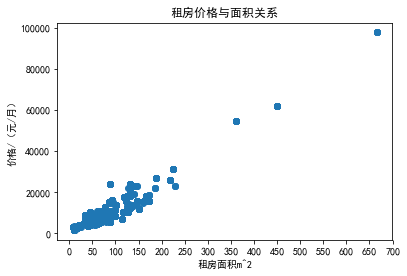

In [44]:
print(data[0])
price = []
area = []
for item in data:
    price.append(item[3])
    area.append(item[5])
# print(price,area)

from matplotlib.pyplot import MultipleLocator #从pyplot导入MultipleLocator类，这个类用于设置刻度间隔
x_major_locator=MultipleLocator(50)
ax=plt.gca()  #ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)  #把x轴的主刻度设置为1的倍数
plt.title("租房价格与面积关系")
plt.xlabel("租房面积m^2")
plt.ylabel("价格/（元/月）")
plt.scatter(area,price)


# 数据进一步清洗
## 可以看出大部分数据集中在0-200m^2面积段，根据常识以及数据分布情况将其余数据删除

In [47]:
conn = sqlite3.connect(dbpath)  # 该 API 打开一个到 SQLite 数据库文件 database 的链接，如果数据库成功打开，则返回一个连接对象
cursor=conn.cursor()        # 该例程创建一个 cursor，将在 Python 数据库编程中用到。
sql = "delete from house where area>200"
cursor.execute(sql)    #该例程执行一个 SQL 语句
conn.commit()
conn.close()
 # 注意sqlite3 只支持单线程操作，保证数据库没有被其他软件打开

(1, 'https://bj.zu.ke.com/zufang/BJ2690606614691987456.html', '整租·海晟名苑北区 1室0厅 西', 7450, '整租', 46, '西')


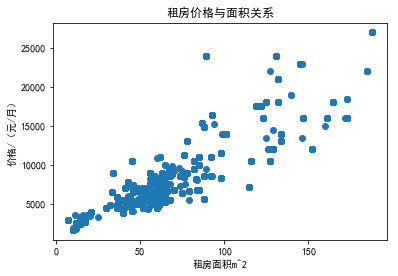

In [50]:
sql = "select * from house"
data = readFronSqllite(dbpath,sql)
print(data[0])
price = []
area = []
toward = []
for item in data:
    price.append(item[3])
    area.append(item[5])
    toward.append(item[-1])
    
# print(price,area)

from matplotlib.pyplot import MultipleLocator #从pyplot导入MultipleLocator类，这个类用于设置刻度间隔
x_major_locator=MultipleLocator(50)
ax=plt.gca()  #ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)  #把x轴的主刻度设置为1的倍数
plt.title("租房价格与面积关系")
plt.xlabel("租房面积m^2")
plt.ylabel("价格/（元/月）")
plt.scatter(area,price)


[331, 423, 184, 755]


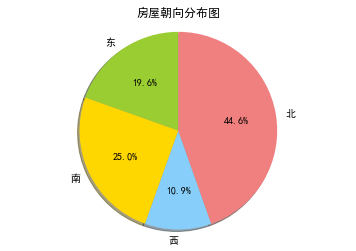

In [57]:
# print(toward)
#定义饼状图的标签
li = ["东","南", "西", "北"]
num = []  #记录每一个饼状图的比例
for i in li:
    num.append(toward.count(i))
print(num) 

#定义每一块的颜色
colors=['yellowgreen','gold','lightskyblue','lightcoral']
plt.title("房屋朝向分布图")
plt.pie(num,labels=li,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.axis('equal')
plt.show()

In [66]:
import pandas as pd
from pyecharts.charts import Pie
from pyecharts import options as opts
data_price = pd.DataFrame({"price":price})
# cats1 = pd.cut(data['value'].values, bins=[18, 25, 35, 60, 90,data['value'].max()+1])
# pinshu = cats1.value_counts() 

cut_n=list(range(0,30000,3000))
income=pd.cut(data_price["price"],cut_n)
price_cut=data_price["price"].groupby(income).count()
index=list(price_cut.index)
index=[str(i) for i in list(price_cut.index)]
values=[int(i) for i in list(price_cut.values)]
pie = (
    Pie()
   .add(
        "",
        [(i,j)for i,j in zip(index,values)],
        radius=["30%", "75%"],
        center=["40%", "50%"],
        rosetype="radius",
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="北京市东城区出租房价格占比"),
        legend_opts=opts.LegendOpts(type_="scroll", pos_left="85%", orient="vertical"),)
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}:  {c}, {d}%"))
)
pie.render_notebook()